In [3]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt

In [39]:
%matplotlib inline

In [5]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [15]:
importlib.reload(lf)

<module 'letkf_forecasting' from '/home/travis/python_code/letkf_forecasting/letkf_forecasting.py'>

In [287]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_15.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [288]:
clear_sky_good = xr.DataArray(
    data=sat_15.GHI.values/sat_14.GHI.values,
    coords=sat_15.coords)

sat_15['clear_sky_good'] = clear_sky_good

In [289]:
sensor_CI = sensor_data[['clearsky_index', 'id']]
sensor_CI = sensor_CI.reset_index().pivot(
    index='time', columns='id', values='clearsky_index')
sensor_CI = sensor_CI.resample('5min').mean().dropna() ##Use scipy interpolate instead of this.

In [111]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5*(2*np.pi)/360
goes15_elevation = 44.1*(2*np.pi)/360

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([ 4502.7974688]), array([ 2902.55179225]))

0.129006870048
0.129009016766


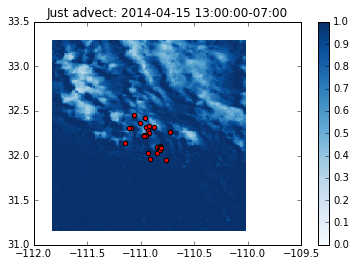

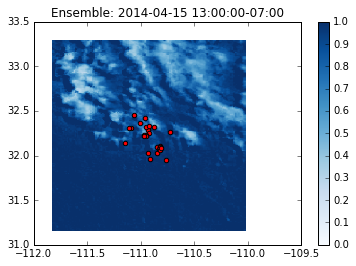

0.128841033073
0.127952782501


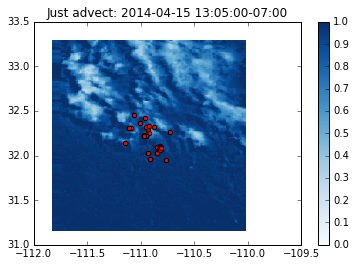

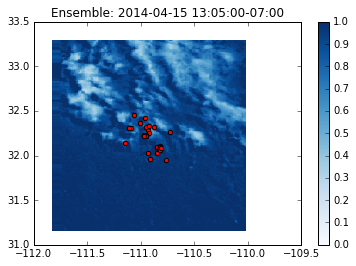

0.231128986527
0.21810983755


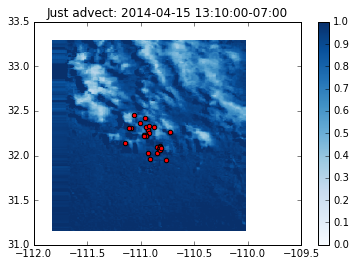

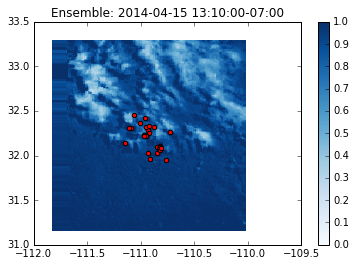

0.17676835805
0.146402038925


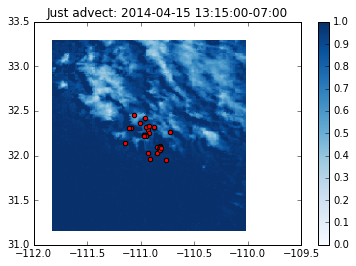

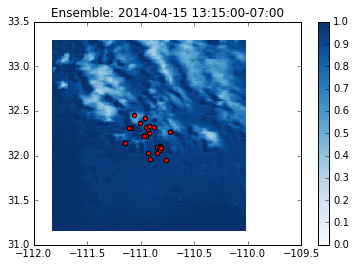

In [ ]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = .01
sensor_sig = .1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .03

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

lf.simulation(sat=sat_15, wind=wind_15, sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)

In [248]:
# Better Crop should write as a function into letkf_forecasting
long_min = sensor_loc['lon'].min()
long_max = sensor_loc['lon'].max()
lat_min = sensor_loc['lat'].min()
lat_max = sensor_loc['lat'].max()
long = sat_15.long.values
lat = sat_15.lat.values
min_x = abs(long[0, :] - long_min).argmin()
max_x = abs(long[0, :] - long_max).argmin()
min_y = abs(lat[:, 0] - lat_min).argmin()
max_y = abs(lat[:, 0] - lat_max).argmin()

U_max = wind_15.U.max() # know U is positive
V_max = abs(wind_15.V.min()) # know V is negative

left = int(U_max*60*30/250) + 20
right = 20

up = int(V_max*60*30/250) + 20
down = 20

x_crop = slice(min_x - left, max_x + right)
y_crop = slice(min_y - down, max_y + up)
print('X length: ' + 
      str(max_x + right - (min_x - left)))
print('Y length: ' + 
      str(max_y + up - (min_y - down)))

X length: 469
Y length: 330


In [ ]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = 0.1 #0.01
sensor_sig = 0.01 #0.1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 14:00:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

lf.simulation(sat=sat_15.isel(y=x_crop, x=y_crop),
              wind=wind_15.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                south_north=y_crop, south_north_stag=y_crop_stag),
              sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)

In [265]:
import scipy.ndimage.filters as filters

In [307]:
U = filters.uniform_filter(wind_15.U, (0, 300, 300), mode='mirror')
V = filters.uniform_filter(wind_15.V, (0, 300, 300), mode='mirror')

In [308]:
wind_15_smooth = wind_15.copy()

In [309]:
wind_15_smooth['U'] = (wind_15.U.dims, U)
wind_15_smooth['V'] = (wind_15.V.dims, V)

In [320]:
pd.DatetimeIndex(sat_15.time.values).tz_localize('UTC').tz_convert('MST')

DatetimeIndex(['2014-04-15 07:00:00-07:00', '2014-04-15 07:15:00-07:00',
               '2014-04-15 07:30:00-07:00', '2014-04-15 07:45:00-07:00',
               '2014-04-15 08:00:00-07:00', '2014-04-15 08:30:00-07:00',
               '2014-04-15 08:45:00-07:00', '2014-04-15 09:00:00-07:00',
               '2014-04-15 09:15:00-07:00', '2014-04-15 09:30:00-07:00',
               '2014-04-15 09:45:00-07:00', '2014-04-15 10:00:00-07:00',
               '2014-04-15 10:15:00-07:00', '2014-04-15 10:30:00-07:00',
               '2014-04-15 10:45:00-07:00', '2014-04-15 11:00:00-07:00',
               '2014-04-15 11:30:00-07:00', '2014-04-15 11:45:00-07:00',
               '2014-04-15 12:00:00-07:00', '2014-04-15 12:15:00-07:00',
               '2014-04-15 12:30:00-07:00', '2014-04-15 12:45:00-07:00',
               '2014-04-15 13:00:00-07:00', '2014-04-15 13:15:00-07:00',
               '2014-04-15 13:30:00-07:00', '2014-04-15 14:00:00-07:00',
               '2014-04-15 14:30:00-07:00', '2014-0

In [323]:
print(int(3))

3


In [324]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = 0.1 #0.01
sensor_sig = 0.01 #0.1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 14:00:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)



lf.trimmed_simulation(sat=sat_15.isel(y=x_crop, x=y_crop),
              wind=wind_15.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                south_north=y_crop, south_north_stag=y_crop_stag),
              sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)

3
3
6
